In [3]:
import os
import sys
import numpy as np
import warnings
import pandas as pd
import matplotlib
from scipy import special
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

root_path = root_path = os.path.realpath('../../../..')
try:
    import auto_causality
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "auto-causality"))

from auto_causality import AutoCausality
from auto_causality.data_utils import preprocess_dataset
from auto_causality.scoring import Scorer

warnings.filterwarnings("ignore")

/Users/madiba/Documents/auto-causality/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Data Generation Process

Here we use a data generation process implemented by EconML for IV models and described as follows:

We construct the DGP as below. The instrument corresponds to a fully randomized recommendation of treatment. Then each sample complies with the recommendation to some degree. This probability depends on both the observed feature $X$ and an unobserved confounder that has a direct effect on the outcome


\begin{align}
W \sim \; & \text{Normal}(0,\, I_{n_w})   \tag{Observed confounders}\\
Z \sim \; & \text{Bernoulli}(p=0.5)   \tag{Instrument}\\
\nu \sim \; & \text{U}[0, 5] \tag{Unobserved confounder}\\
C \sim \; & \text{Bernoulli}(p=0.8 \cdot \text{Sigmoid}(0.4 \cdot X[0] + \nu))   \tag{Compliers when recommended}\\
C0 \sim \; & \text{Bernoulli}(p=0.006)   \tag{Non-Compliers when not recommended}\\
T = \; & C \cdot Z + C0 \cdot (1-Z)  \tag{Treatment}\\
y \sim \; & \theta \cdot T + 2 \cdot \nu + 5 \cdot (X[3]>0) + 0.1 \cdot \text{U}[0, 1]  \tag{Outcome}
\end{align}


In [4]:
def iv_dgp_econml(n=5000, p=10, true_effect=10):

    X = np.random.normal(0, 1, size=(n, p))
    Z = np.random.binomial(1, 0.5, size=(n,))
    nu = np.random.uniform(0, 5, size=(n,))
    coef_Z = 0.8
    C = np.random.binomial(
        1, coef_Z * special.expit(0.4 * X[:, 0] + nu)
    )  # Compliers when recomended
    C0 = np.random.binomial(
        1, 0.006 * np.ones(X.shape[0])
    )  # Non-compliers when not recommended
    T = C * Z + C0 * (1 - Z)
    y = (
        true_effect(X) * T
        + 2 * nu
        + 5 * (X[:, 3] > 0)
        + 2.5 * np.random.uniform(0, 1, size=(n,))
    )
    cov = [f"x{i}" for i in range(1, X.shape[1] + 1)]
    df = pd.DataFrame(X, columns=cov)

    df["y"] = y
    df["treatment"] = T
    df["Z"] = Z

    return df

In [5]:
# Dataset parameters
treatment = "treatment"
targets = ["y"]
instruments = ["Z"]
outcome = targets[0]

In [7]:
TRUE_EFFECT = 5.5

In [6]:
estimator_list = ["SimpleIV", "SparseLinearDRIV", "DMLIV",  "LinearDRIV", "LinearIntentToTreatDRIV", "ForestDRIV", "IntentToTreatDRIV"]

 We get the estimated effect for the best estimator by energy distance score

In [8]:
# score all estimators on the test set
def score_all_test(models, test_set):
    for est_name, scr in models.scores.items():
        try:
            causal_estimate = scr['estimator']
            # print(causal_estimate.estimator._treatment_name)
            scr['scores']['test'] = models.scorer.make_scores(
                causal_estimate,
                test_set,
                problem=models.problem,
                metrics_to_report=models.metrics_to_report
            )
        except Exception as e:
            print(e)
            pass


def ate_mse(scores, true_effect=TRUE_EFFECT):
    return  [(v-true_effect)**2 for v in scores]


In [9]:
def get_est_effects(models, test_x, te=TRUE_EFFECT):
    est_scores = []
    for est_name, scr in models.scores.items():
        est_effect = scr["estimator"].estimator.effect(test_x).mean()
        energy_distance = scr["scores"]["test"]["energy_distance"]
        est_scores.append([est_name, est_effect, (est_effect-te)**2, energy_distance])

    return pd.DataFrame(est_scores, columns=["estimator", "estimated_effect", "ate_mse", "energy_distance"])


In [10]:
%matplotlib inline

def graph_compare_estimators(model):
    colors = ([matplotlib.colors.CSS4_COLORS['black']] +
        list(matplotlib.colors.TABLEAU_COLORS) + [
        matplotlib.colors.CSS4_COLORS['lime'],
        matplotlib.colors.CSS4_COLORS['yellow'],
        matplotlib.colors.CSS4_COLORS['pink']
    ])


    plt.figure(figsize = (7,5))
    plt.title(outcome)

    m1 = "energy_distance"
    m2 = "ate"

    splits =  ["train", "validation", "test"]

    for (est, scr), col in zip(model.scores.items(), colors):
        try:
            scores  = scr["scores"]
            sc = [scores[v][m1] for v in splits]
            crv = ate_mse([scores[v][m2] for v in splits])
            plt.plot(sc, crv, color=col, marker="o", label=est)
            plt.scatter(sc[1:2],crv[1:2], c=col, s=70, label="_nolegend_" )
            plt.scatter(sc[2:],crv[2:], c=col, s=120, label="_nolegend_" )

        except Exception as e:
            print(e)
            pass

    plt.xlabel(m1)
    plt.ylabel(f"{m2}_MSE")
    plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

    plt.grid()
    plt.show()


First we see the estimated effect for each model, and respective MSE compared with true effect

In the plots we show the energy distance scores on the train, validation and hold-out test sets compared with the mean squared error between estimated effect and the true effect

In [55]:
# Get non-optimal runs from each estimator and score on (energy distance, ate)
# ac_constant_te.results.results

### Model Fitting (2): Heterogeneous Treatment Effect

Here we replace the constant treatment effect with a linear treatment effect function of some covariates  to estimate heterogeneous effects.

\begin{align}
\theta = \; & 5.5  \cdot   (X[2] + X[7]) \tag{ATE}\\
\end{align}

In [11]:
LINEAR_EFFECT = lambda X: TRUE_EFFECT * (X[:, 0] ** 2) * (X[:, 1])

synth_data = iv_dgp_econml(n=70000, p=15, true_effect=LINEAR_EFFECT)
data_df, features_X, features_W = preprocess_dataset(
    synth_data, treatment, targets, instruments
)
df_train, df_test = train_test_split(data_df, test_size=0.3)

Xtest = data_df[features_X[:2]]
df_train.head()

,treatment,y,Z,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,random
48423,1.0,1.725671,1.0,-0.537809,-0.124271,0.795699,-0.834219,-0.256867,-0.278977,1.301755,-0.174008,-1.363742,-0.038583,-0.516141,-0.209794,-0.124095,0.285175,-0.037572,0.0
23140,0.0,3.632314,1.0,-1.405308,-1.019279,0.648146,-1.911916,0.763641,-1.197723,-0.063461,0.235379,-0.188018,-1.178343,0.836244,-0.313461,-0.088779,0.385072,-0.940476,1.0
374,0.0,3.018122,1.0,-0.614374,-1.110493,0.704305,-0.719564,-0.735482,1.095563,0.049356,-1.138341,0.101717,1.556851,1.120560,-0.339383,1.815382,-0.255806,0.526907,1.0
56363,0.0,12.273410,0.0,-0.189886,2.060669,-1.579035,1.168288,1.268015,0.915415,-0.749019,0.290776,-1.432303,-0.658196,-0.678912,0.101040,-1.029162,-0.672465,-0.242024,0.0
48898,1.0,10.685102,1.0,0.368245,0.751106,-0.708196,2.385056,-0.895128,0.171010,1.866754,-1.192084,-0.389994,1.428801,-0.864667,0.947921,-0.773965,-1.219181,-0.421374,0.0


In [12]:
ac_linear_te = AutoCausality(
    estimator_list=estimator_list,
    verbose=3,
    components_verbose=2,
    time_budget=72000,
    components_time_budget=1200,
    propensity_model="auto",
    train_size=0.8
)

ac_linear_te.fit(df_train, treatment, outcome, features_X[2:], features_X[:2], instruments)

Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks


[flaml.automl: 09-28 00:49:09] {2648} WARNING - Time taken to find the best model is 94% of the provided time budget and not all estimators' hyperparameter search converged. Consider increasing the time budget.
[flaml.tune.tune: 09-28 00:49:09] {375} WARNING - Using CFO for search. To use BlendSearch, run: pip install flaml[blendsearch]
[flaml.tune.tune: 09-28 00:49:09] {506} INFO - trial 1 config: {'estimator': {'estimator_name': 'iv.auto_causality.models.SimpleIV'}}


Initial configs: [{'estimator': {'estimator_name': 'iv.auto_causality.models.SimpleIV'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearDRIV', 'projection': True}}, {'estimator': {'estimator_name': 'iv.econml.iv.dml.DMLIV', 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.IntentToTreatDRIV', 'opt_reweighted': 0, 'cov_clip': 0.1, 'prel_opt_reweighted': 1, 'prel_cate_approach': 'driv'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.SparseLinearDRIV', 'projection': 0, 'opt_reweighted': 0, 'cov_clip': 0.1}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.ForestDRIV', 'projection': 0, 'opt_reweighted': 0, 'cov_clip': 0.1, 'min_samples_split': 2}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearIntentToTreatDRIV', 'cov_clip': 0.1, 'opt_reweighted': 1}}]


RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
[flaml.tune.tune: 09-28 00:50:01] {118} INFO - result: {'energy_distance': 0.14279393038355437, 'estimator_name': 'iv.auto_causality.models.SimpleIV', 'scores': {'train': {'intrp': <econml.cate_interpreter._interpreters.SingleTreeCateInterpreter object at 0x28c660a60>, 'ate': -0.13644225895404816, 'ate_std': 0.0, 'energy_distance': 0.1347389441280411}, 'validation': {'intrp': <econml.cate_interpreter._interpreters.SingleTreeCateInterpreter object at 0x28c5f7f70>, 'ate': -0.13644225895404816, 'ate_std': 0.0, 'energy_distance': 0.14279393038355437}}, 'conf

In [28]:
len(ac_linear_te.results.results)

In [34]:
ac_linear_te.__dict__

{'_settings': {'tuner': {'time_budget_s': 72000,
   'num_samples': -1,
   'verbose': 3,
   'use_ray': False,
   'resources_per_trial': {'cpu': 0.5}},
  'try_init_configs': True,
  'component_models': {'task': 'regression',
   'verbose': 2,
   'pred_time_limit': 1e-05,
   'n_jobs': -1,
   'time_budget': 1200},
  'train_size': 0.8,
  'test_size': None},
 'metric': 'energy_distance',
 'metrics_to_report': ['energy_distance'],
 'propensity_model': AutoML(append_log=False, auto_augment=True, custom_hp={}, early_stop=False,
        ensemble=False, estimator_list='auto', eval_method='auto',
        fit_kwargs_by_estimator={}, hpo_method='auto', keep_search_state=False,
        learner_selector='sample', log_file_name='', log_training_metric=False,
        log_type='better', max_iter=None, mem_thres=4294967296, metric='auto',
        metric_constraints=[('pred_time', '<=', 1e-05)], min_sample_size=10000,
        model_history=False, n_concurrent_trials=1, n_jobs=-1, n_splits=5,
        pred_ti

In [38]:
# Evaluation

import numpy as np

def mse_heffects(estimator, test_cov, labels):
    est_effect = estimator.effect(test_cov)
    mse = np.square(est_effect - labels).mean()
    
    return mse

In [39]:
df_test[['x1', 'x2']].values.shape

CATE_VALUES = lambda x, y: TRUE_EFFECT * (x ** 2) * y
test_covals = df_test[['x1', 'x2']].values
x, y = test_covals[:, 0], test_covals[:, 1]

cate_effect_vals = CATE_VALUES(x, y)

[Text(0.5, 0, 'MSE'),
 Text(0, 0.5, 'test_score'),
 Text(0.5, 1.0, 'energy_distance')]

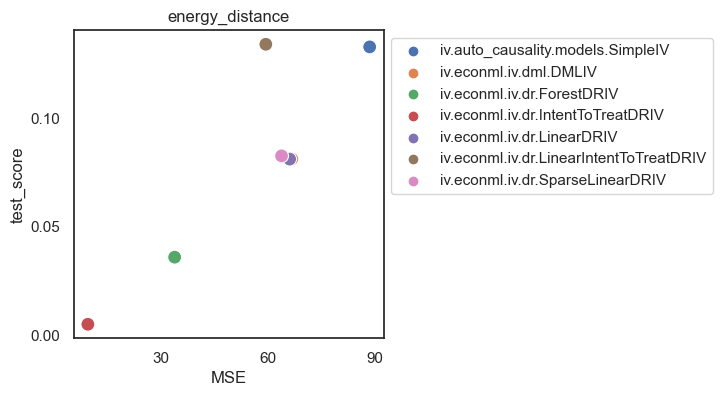

In [61]:
import seaborn as sns


stats = []
for est_name, scr in ac_linear_te.scores.items():
    estimator = scr["estimator"].estimator
    
    mse_test = mse_heffects(estimator, df_test[features_X[:2]], cate_effect_vals)

    energy_distance = ac_linear_te.scorer.make_scores(
                scr["estimator"],
                df_test,
                problem=ac_linear_te.problem,
                metrics_to_report=ac_linear_te.metrics_to_report
            )["energy_distance"]
    

    stats.append([est_name, mse_test, energy_distance])

df_stats = pd.DataFrame(stats, columns=["estimator", "mse", "energy_distance"])

plt.figure(figsize=(4, 4))

sns.set(font_scale=2.5)
sns.set_theme(style='white')

g = sns.scatterplot(
    df_stats,
    x="mse",
    y="energy_distance",
    hue="estimator",
    s=100
)

import matplotlib.ticker as ticker


g.xaxis.set_major_locator(ticker.MultipleLocator(30))
g.xaxis.set_major_formatter(ticker.ScalarFormatter())

g.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
g.yaxis.set_major_formatter(ticker.ScalarFormatter())

g.legend(title="")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

# legend = g.legend()
# legend.texts[0].set_text("")

g.set(xlabel="MSE", ylabel="test_score", title="energy_distance")
   

In [25]:
import pickle

# model_file = open("model.pkl", "rb")
with open("model.pkl", "rb") as f:
    model = pickle.load(f)
model.results

EOFError: Ran out of input

In [85]:
from cProfile import label


def get_scores(results_dict, te=TRUE_EFFECT):
    all_scores = list()
    for label, scores in results_dict.items():
        val_scores = scores["scores"]["validation"]
        ate = val_scores["ate"]
        energy_distance = val_scores["energy_distance"]
        all_scores.append([energy_distance, (te-ate)**2])
    return all_scores


def all_estimator_scatter(results, best_estimators, title):
    all_scores = get_scores(results)
    best_scores = get_scores(best_estimators)
    estimators = list(best_estimators.keys())

    fig, ax = plt.subplots(figsize=(9, 7))
    
    for est in all_scores:
        ax.scatter(est[1], est[0], c="gray", label="_nolegend_")
    for i, est in enumerate(best_scores):
        print(est)
        ax.scatter(est[1], est[0], label=estimators[i])
    
    ax.set_ylabel("test score")
    ax.set_xlabel("MSE")
    ax.set_title("energy_distance")
    ax.legend()
    plt.show()

Here, we compare the best run(s) - orange dots - for the selected estimator(s), compared with intermediate runs - grey dots.

[0.22867408617253382, 43.22900215509673]
[0.14344045826186225, 44.243809829795076]
[0.21031591646680425, 44.18064106937167]
[0.013732010545933093, 43.309065467755715]
[0.1581589010732456, 44.38416319592103]


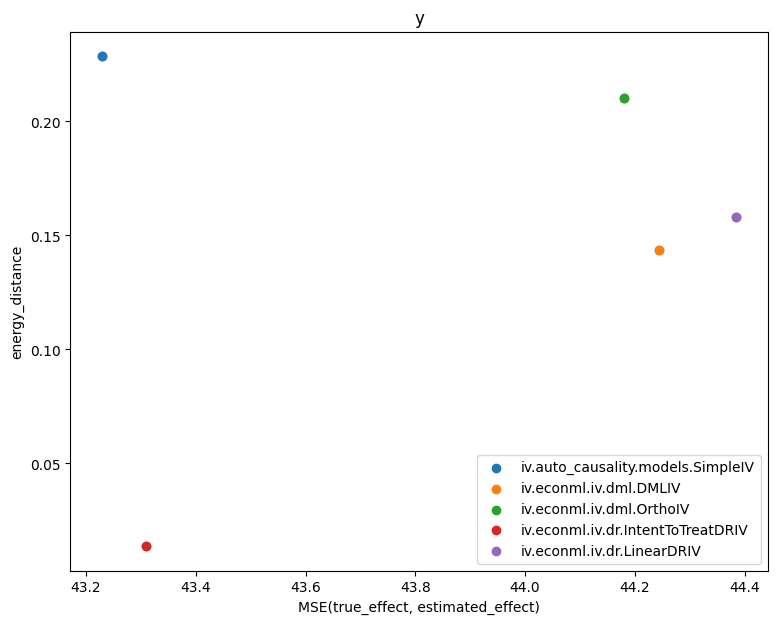

In [86]:
all_estimator_scatter(
    ac_linear_te.results.results,
    ac_linear_te.scores,
    title="linear_cate"
)

In [64]:
Xtest = test_df[features_X[:2]]
get_est_effects(ac_linear_te, Xtest)

,estimator,estimated_effect,ate_mse,energy_distance
0,iv.auto_causality.models.SimpleIV,0.125123,43.229002,0.208813
1,iv.econml.iv.dml.DMLIV,-0.017493,45.124719,0.130863
2,iv.econml.iv.dml.OrthoIV,-0.086598,46.057914,0.199842
3,iv.econml.iv.dr.IntentToTreatDRIV,-0.026285,45.242911,0.011017
4,iv.econml.iv.dr.LinearDRIV,-0.065063,45.766084,0.148137


In [60]:
score_all_test(ac_linear_te, df_test)
get_est_effects(ac_linear_te, Xtest)
graph_compare_estimators(ac_linear_te)

KeyError: 'test'

In [66]:
import pickle

with open("8h_80K.pkl", "wb") as f:
    pickle.dump(ac_linear_te, f)

AttributeError: Can't pickle local object 'AutoCausality.fit.<locals>.<lambda>'

### Model Fitting (3): Non-linear Heterogeneous Treatment Effect

Finally we explore non-linear heterogeneous treatment effects with the function below:

\begin{align}
\theta = \; & 7.5  \cdot   (X[2] + X[7]) \tag{ATE}\\
\end{align}


In [30]:
QUADRATIC_EFFECT = lambda X: TRUE_EFFECT * (X[:, 2] ** 2) * (X[:, 7] ** 3) 

data = iv_dgp_econml(n=10000, p=15, true_effect=QUADRATIC_EFFECT)
data_df, features_X, features_W = preprocess_dataset(
    data, treatment, targets, instruments
)
outcome = targets[0]
train_df, test_df = train_test_split(data_df, test_size=0.3)
Xtest = test_df[features_X]
train_df.head()

,treatment,y,Z,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,random
1749,0.0,7.962746,0.0,-0.930624,1.162991,0.729456,-0.273677,0.689983,-0.542694,0.342018,-0.986162,0.334147,-0.522664,-0.760399,-0.696916,-0.250714,-0.925333,-0.308684,0.0
8753,0.0,7.466413,1.0,0.098788,0.561751,1.067532,-0.954808,0.157062,-1.942514,-1.290649,-1.146356,-0.172148,0.545423,-0.239812,-0.914031,-0.801335,2.295311,-2.074314,1.0
2376,0.0,3.807416,0.0,1.211798,0.320737,0.285181,-0.475356,1.627070,-0.820177,0.193067,-0.743845,0.394570,0.736218,0.934503,1.313644,1.574028,-1.220983,-0.814131,1.0
5866,0.0,12.620029,0.0,1.142354,0.262738,0.939899,0.564811,0.365819,0.764096,-1.760255,-0.410142,1.154539,-0.685998,0.255347,0.375952,-0.738155,-0.735688,0.734578,0.0
7097,0.0,13.829594,0.0,0.037404,-0.237903,-0.971907,1.921247,-1.191215,-0.365760,0.824570,-0.665056,0.294414,-0.598442,-1.346559,-0.393804,0.444747,-0.322192,1.439316,1.0


In [31]:
ac_quad_te = AutoCausality(
    estimator_list=estimator_list,
    verbose=3,
    components_verbose=2,
    components_time_budget=30,
    propensity_model="auto",
    train_size=0.8
)

ac_quad_te.fit(train_df, treatment, outcome, features_W, features_X, instruments)


Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks


[flaml.tune.tune: 09-20 22:45:29] {375} WARNING - Using CFO for search. To use BlendSearch, run: pip install flaml[blendsearch]
[flaml.tune.tune: 09-20 22:45:29] {506} INFO - trial 1 config: {'estimator': {'estimator_name': 'iv.auto_causality.models.SimpleIV'}}


Initial configs: [{'estimator': {'estimator_name': 'iv.auto_causality.models.SimpleIV'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearDRIV', 'projection': True}}, {'estimator': {'estimator_name': 'iv.econml.iv.dml.OrthoIV', 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dml.DMLIV', 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.IntentToTreatDRIV', 'opt_reweighted': 0, 'cov_clip': 0.1, 'prel_opt_reweighted': 1, 'prel_cate_approach': 'driv'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.SparseLinearDRIV', 'projection': 0, 'opt_reweighted': 0, 'cov_clip': 0.1}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.ForestDRIV', 'projection': 0, 'opt_reweighted': 0, 'cov_clip': 0.1, 'min_samples_split': 2}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearIntentToTreatDRIV', 'cov_clip': 0.1, 'opt_reweighted': 1}}]


RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
[flaml.tune.tune: 09-20 22:45:33] {118} INFO - result: {'energy_distance': 0.5016108513784632, 'estimator_name': 'iv.auto_causality.models.SimpleIV', 'scores': {'train': {'intrp': <econml.cate_interpreter._interpreters.SingleTreeCateInterpreter object at 0x1665569d0>, 'ate': -1.8753958940505981, 'ate_std': 0.0, 'energy_distance': 0.4150975522394269}, 'validation': {'intrp': <econml.cate_interpreter._interpreters.SingleTreeCateInterpreter object at 0x166556b20>, 'ate': -1.8753958940505981, 'ate_std': 0.0, 'energy_distance': 0.5016108513784632}}, 'config':

In [33]:
get_est_effects(ac_quad_te, Xtest)

,estimator,estimated_effect,ate_mse
0,iv.auto_causality.models.SimpleIV,-1.875396,87.898048
1,iv.econml.iv.dml.DMLIV,-0.545693,64.733176
2,iv.econml.iv.dml.OrthoIV,-0.907341,70.683388
3,iv.econml.iv.dr.IntentToTreatDRIV,-1.341814,78.177668
4,iv.econml.iv.dr.LinearDRIV,-0.406059,62.505762


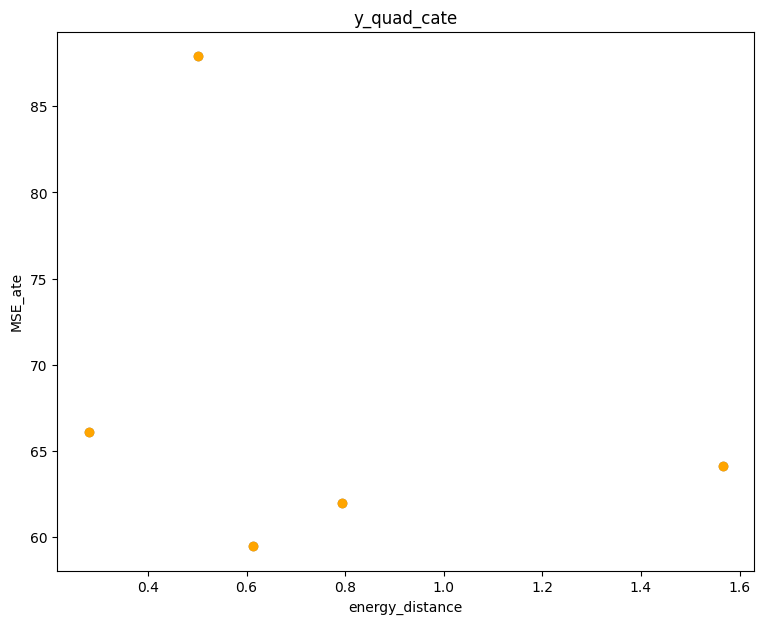

In [32]:
all_estimator_scatter(
    ac_quad_te.results.results,
    ac_quad_te.scores,
    title="quad_cate"
)

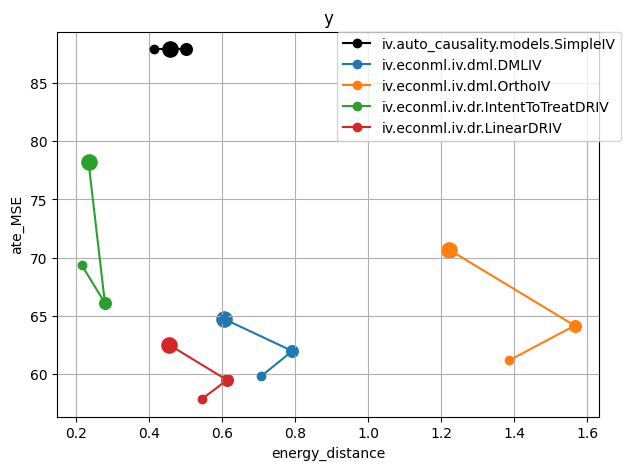

In [34]:
score_all_test(ac_quad_te, test_df)
graph_compare_estimators(ac_quad_te)
